# iLykei Lecture Series

# Advanced Machine Learning and Artificial Intelligence (MScA 32017)

# Project: Generative Models

# Topic: Unconditional Generative Adversarial Networks (DCGANs)

## Notebook 1: Training Unconditional DCGAN


## Yuri Balasanov, &copy; iLykei 2019

##### Main texts: 

**[Generative Adversarial Networks, Ian J. Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, Yoshua Bengio, arXiv:1406.2661 [stat.ML]](https://arxiv.org/abs/1406.2661)**

**[Conditional Generative Adversarial Nets, Mehdi Mirza, Simon Osindero, arXiv:1411.1784 [cs.LG]](https://arxiv.org/abs/1411.1784)**

**[How to Develop a Conditional GAN (cGAN) From Scratch, Jason Brownlee, 2019](https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/)**    

This notebook shows how to construct an unconditional deep convolutional GAN (DCGAN) and train it on Fashion MNIST data.

In [1]:
import numpy as np
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

Using TensorFlow backend.


In [2]:
#### Remove when running on GPU
from matplotlib import pyplot as plt
from keras.utils import plot_model

# Data

Load and print the data: only training images are necessary for DCGAN. 

In [3]:
#from keras.datasets import mnist, fashion_mnist
# load MNIST or FASHION_MNIST dataset
#(x_train, y_train), (_, _) = mnist.load_data()
#(x_train, y_train), (_, _) = fashion_mnist.load_data()

#np.save('x_train.npy',x_train)
#np.save('y_train.npy',y_train)
#np.save('x_train_fashion.npy',x_train)
#np.save('x_train_fashion.npy',y_train)
#x_train=np.load('x_train.npy')
#y_train=np.load('y_train.npy')
x_train=np.load('x_train_fashion.npy')
y_train=np.load('y_train_fashion.npy')

Print first 60 images, add label data at x-axis.

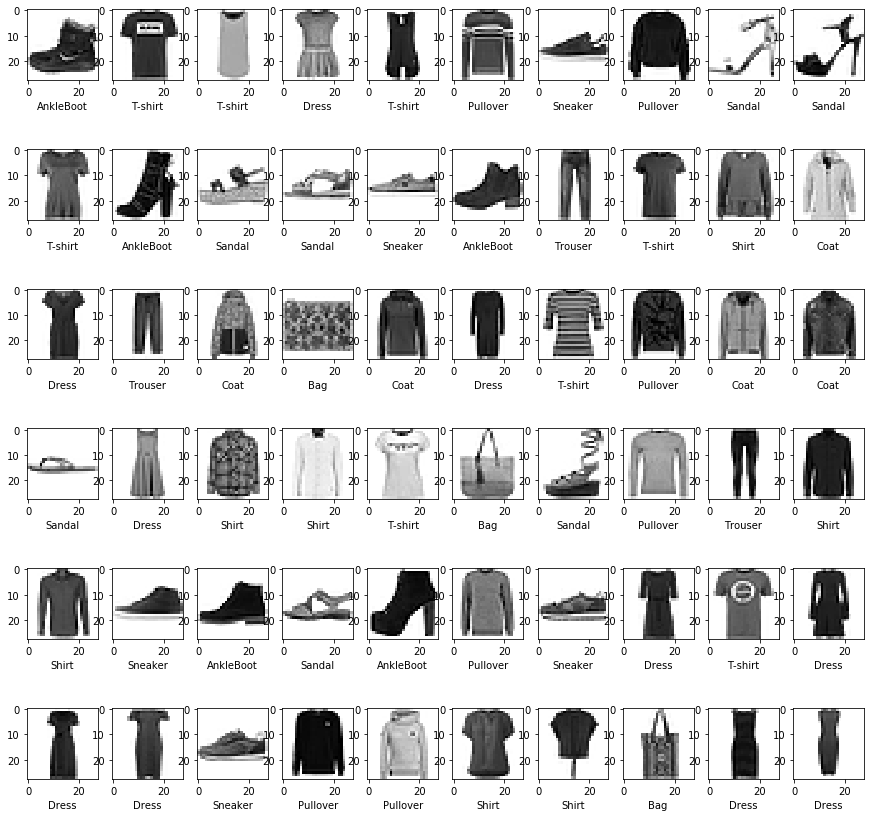

In [4]:
#### Remove when running on GPU
LabelData = {
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'AnkleBoot'
}

# plot images 
plt.figure(figsize=(15,15))
for i in range(60):
    plt.subplot(6, 10, 1 + i)
    plt.imshow(x_train[i], cmap='gray_r')
    plt.xlabel(LabelData[y_train[i]])
plt.show()

# Model

## Discriminator

Create function building the discriminator model. Check the number of trainable parameters.

Architecture of the descriminator is pretty simple: 

- Input is one `(28,28,1)` image
- Pass it through 2 consecutive downsamples by `Conv2D` with 128 units
- Complete the architecture with standard binary classifier sequence of flattening, dropout and single output unit with sigmoid activation.

In [5]:
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

Print summary and plot the architecture of the discriminator model.

In [6]:
# Remove when running on GPU
discriminator_structure = define_discriminator()
plot_model(discriminator_structure, to_file='discriminator_structure.png',show_shapes=True,show_layer_names=True)
discriminator_structure.summary()

W0721 23:10:51.525742 140596097161024 deprecation_wrapper.py:119] From /home/yuri/anaconda3/envs/newtf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0721 23:10:51.547312 140596097161024 deprecation_wrapper.py:119] From /home/yuri/anaconda3/envs/newtf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0721 23:10:51.550501 140596097161024 deprecation_wrapper.py:119] From /home/yuri/anaconda3/envs/newtf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0721 23:10:51.616469 140596097161024 deprecation_wrapper.py:119] From /home/yuri/anaconda3/envs/newtf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecate

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 128)       1280      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6273      
Total para

The discriminator has 155,137 parameters, all are trainable.

Discriminator structure:
![Discriminator Structure](discriminator_structure.png)

## Generator

Create function building generator model. 

- Input is a random vector of `latent_dim` variables
- Pass it to a 6,272-unit dense layer followed by reshaping it into `(7,7,128)` feature set of 128 `(7,7)`-images
- Upsample twice from (7,7,128) - to (14,14,128) - to (28,28,128)
- Finally generate output image of shape `(28,28,1)`.

In [7]:
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # generate
    model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
    return model

In [8]:
# Remove when running on GPU
generator_structure = define_generator(latent_dim=100)
plot_model(generator_structure, to_file='generator_structure.png',show_shapes=True,show_layer_names=True)
generator_structure.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 28, 28, 128)       0         
__________

Generator has 1,164,289 parameters, all are trainable.

Generator structure:

![Generator Structure](generator_structure.png)

## Adversarial model

Create function building the adversarial (DCGAN) model as superposition of generator and discriminator. The purpose of the adversarial model is training the generator while observing errors made by the discriminator. Weights of the discriminator in the adversarial model remain fixed. Weights of the discriminator in the adversarial model remain fixed.

In [9]:
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

Check summary and plot of the adversarial model.

In [10]:
# Remove when running on GPU
gan_structure = define_gan(generator_structure, discriminator_structure)
plot_model(gan_structure, to_file='gan_structure.png',show_shapes=True,show_layer_names=True)
gan_structure.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 155137    
Total params: 1,319,426
Trainable params: 1,164,289
Non-trainable params: 155,137
_________________________________________________________________


Adversarial model has total 1,319,426 parameters, of them only 1,164,289 are trainable (parameters of the generator) and 155,137 are not trainable (parameters of the discriminator).

GAN structure:

![GAN Structure](gan_structure.png)



# Training DCGAN

Create function preparing images: expanding dimensions and rescaling them to interval`[-1,1]`.

In [11]:
def prepare_samples():
    # expand to 3d, e.g. add channels
    X = np.expand_dims(x_train, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X

Create function randomly selecting real images for training DCGAN and labeling them as ones.

In [12]:
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix] # real images
    y = np.ones((n_samples, 1)) # labeled as 1 (true images)
    return X, y

Create function generating `n_samples` random latent vectors of dimension `latent_dim` from standard normal distribution. These vectors are inputs to the generator. 

In [13]:
def generate_latent_points(latent_dim, n_samples):
    # 'n_samples' vectors of 'latent_dim' standard normal numbers each
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

Create function generating fake samples and labeling them as zeros.

In [14]:
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict fake images
    X = generator.predict(x_input)
    y = np.zeros((n_samples, 1)) # label them as zeros
    return X, y

Create function training DCGAN, generator and discriminator. 

This training process will have to be managed manually because it switches between two modes: 
- Training the discriminator while half batch is made of real images labeled as 1 and another half batch is made of fake images labeled as 0. The weights of the generator are frozen during this mode
- Training the generator while all images of the batch are fake and labeled as 1. The weights of the disctiminator are frozen during this mode
In each of the modes update of the weights is done by `train_on_batch()` rather than `fit()`.

The function takes predefined and compiled generator, discriminator and adversarial models and runs alternating steps in each mode.

In [15]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    # batches per epoch
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get half_batch randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update weights of discriminator model on real images
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' images
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights on fake images
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # label fake images as ones to train generator
            y_gan = np.ones((n_batch, 1))
            # update weights of the generator based on the discriminator's errors
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d1= %.3f, d2= %.3f g= %.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    # save the generator model
    g_model.save('try_dc_generator.h5')

Define the models and train them.

In [16]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = prepare_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim,n_epochs=1, n_batch=600)

/home/yuri/anaconda3/envs/newtf/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/yuri/anaconda3/envs/newtf/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/100, d1= 0.696, d2= 0.695 g= 0.692


/home/yuri/anaconda3/envs/newtf/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 2/100, d1= 0.625, d2= 0.699 g= 0.688
>1, 3/100, d1= 0.565, d2= 0.706 g= 0.682
>1, 4/100, d1= 0.507, d2= 0.716 g= 0.674
>1, 5/100, d1= 0.452, d2= 0.728 g= 0.665
>1, 6/100, d1= 0.405, d2= 0.741 g= 0.656
>1, 7/100, d1= 0.361, d2= 0.756 g= 0.648
>1, 8/100, d1= 0.328, d2= 0.774 g= 0.642
>1, 9/100, d1= 0.296, d2= 0.788 g= 0.645
>1, 10/100, d1= 0.286, d2= 0.787 g= 0.665
>1, 11/100, d1= 0.272, d2= 0.746 g= 0.721
>1, 12/100, d1= 0.286, d2= 0.677 g= 0.804
>1, 13/100, d1= 0.286, d2= 0.606 g= 0.898
>1, 14/100, d1= 0.292, d2= 0.555 g= 0.948
>1, 15/100, d1= 0.320, d2= 0.553 g= 0.924
>1, 16/100, d1= 0.295, d2= 0.587 g= 0.854
>1, 17/100, d1= 0.277, d2= 0.640 g= 0.780
>1, 18/100, d1= 0.307, d2= 0.713 g= 0.704
>1, 19/100, d1= 0.224, d2= 0.806 g= 0.633
>1, 20/100, d1= 0.226, d2= 0.896 g= 0.579
>1, 21/100, d1= 0.194, d2= 0.949 g= 0.560
>1, 22/100, d1= 0.172, d2= 0.948 g= 0.581
>1, 23/100, d1= 0.161, d2= 0.909 g= 0.638
>1, 24/100, d1= 0.136, d2= 0.794 g= 0.767
>1, 25/100, d1= 0.128, d2= 0.612 g= 0.993
